In [1]:
import numpy as np
import random
import torch
import time
import pandas as pd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from CNN_ae import SEQUENCE, N_FEATURES, AutoEncoder, AssetDataset
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

# [ time, low, high, open, close, volume ]
data = np.genfromtxt('eggs.csv', delimiter=',')
data = np.flip(data, axis=0)
data = data[:, 1:]
# normalize
min_points, max_points = np.min(data, axis=0), np.max(data, axis=0)
data = (data - min_points) / (max_points - min_points)
# split into equal sequences
# total_rows = data.shape[0]
# PARTS = int(total_rows / SEQUENCE)
# missing = (data.shape[0]) % PARTS
# splits = np.array(np.array_split(data[missing:], PARTS))

# window
splits = np.array([np.array(data[i:i+SEQUENCE])
                    for i in range(len(data)-SEQUENCE)])

In [11]:

import importlib
import CNN_ae
importlib.reload(CNN_ae)

# Hyperparameters
code_size = SEQUENCE
num_epochs = 40
batch_size = 128
lr = 0.001
optimizer_cls = optim.Adam
save_every = 10

dataset = AssetDataset(splits)
train_loader = torch.utils.data.DataLoader(
    dataset, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)

autoencoder = CNN_ae.AutoEncoder(code_size)
# autoencoder = torch.load('model.pt')
autoencoder.train()
loss_fn = nn.MSELoss(reduction='sum')
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)

autoencoder.to(device)

for epoch in range(num_epochs):
    print("Epoch %d" % epoch)

    for i, batch in enumerate(train_loader):
        batch = batch.float()
        batch = batch.to(device)
        out, code = autoencoder(batch)

        optimizer.zero_grad()
        loss = loss_fn(out, batch)
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print(f"Batch: {i}, loss: {loss.item()}")

    print("Loss = %.3f" % loss.item())

    if (epoch+1) % save_every == 0:
        torch.save(autoencoder, f"model_{int(time.time())}_{epoch+1}_{code_size}.pt")

Epoch 0
Batch: 999, loss: 1.3879656791687012
Batch: 1999, loss: 2.043166160583496
Batch: 2999, loss: 5.091796398162842
Loss = 0.712
Epoch 1
Batch: 999, loss: 2.307135581970215
Batch: 1999, loss: 1.5841079950332642
Batch: 2999, loss: 2.1818759441375732
Loss = 0.421
Epoch 2
Batch: 999, loss: 1.1146855354309082
Batch: 1999, loss: 1.1026175022125244
Batch: 2999, loss: 0.82383793592453
Loss = 1.069
Epoch 3
Batch: 999, loss: 0.8276139497756958
Batch: 1999, loss: 0.7349022626876831
Batch: 2999, loss: 0.5366746187210083
Loss = 0.213
Epoch 4
Batch: 999, loss: 0.3175864815711975
Batch: 1999, loss: 0.47857457399368286
Batch: 2999, loss: 0.6686328649520874
Loss = 0.137
Epoch 5
Batch: 999, loss: 0.3810853958129883
Batch: 1999, loss: 0.4912487268447876
Batch: 2999, loss: 0.36517333984375
Loss = 0.147
Epoch 6
Batch: 999, loss: 3.0944364070892334
Batch: 1999, loss: 0.251896470785141
Batch: 2999, loss: 0.6411086320877075
Loss = 0.131
Epoch 7
Batch: 999, loss: 0.5241471529006958
Batch: 1999, loss: 0.191

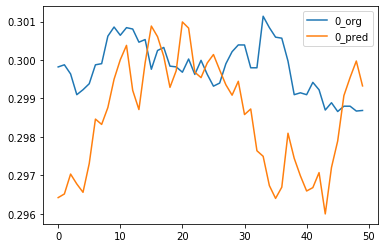

In [3]:

dataset = AssetDataset(splits)

autoencoder = torch.load('model_1616935991_40_50.pt')
autoencoder.eval()
autoencoder.to(device)

for i in range(1):
    test_image = random.choice(dataset)
    test_image = torch.tensor(test_image).view([1, 5, SEQUENCE]).float().to(device)
    test_reconst, _ = autoencoder(test_image)

    test_image = test_image.cpu().detach().numpy()
    test_reconst = test_reconst.cpu().detach().numpy()

    # print(test_image.detach().numpy().shape)
    # print(test_reconst.detach().numpy().shape)

    plt.plot(test_image[0, 0, :], label=f'{i}_org')
    plt.plot(test_reconst[0, 0, :], label=f'{i}_pred')
    
plt.legend()
plt.show()

In [7]:
# window
rl_data = np.array([np.array(data[i:i+SEQUENCE+1])
                    for i in range(len(data)-SEQUENCE-1)])
rl_dataset = AssetDataset(rl_data)

cols = ['state_features','last_n']
d = {}
for c in cols:
    d[c] = []
start = time.time()
LAST_N = 11
for i in range(int(len(rl_dataset)/100)):
    point = rl_dataset[i]
    test_image = point[:,:-1]
    test_image = torch.tensor(test_image).view([1, 5, SEQUENCE]).float().to(device)
    test_reconst, encoded = autoencoder(test_image)

    test_image = test_image.cpu().detach().numpy()
    test_reconst = test_reconst.cpu().detach().numpy()
    encoded = encoded.cpu().detach().numpy()

    features = encoded[0]
    d['state_features'].append(features)

    seq = np.swapaxes(test_image[0][:,-LAST_N:],0,1)
    d['last_n'].append(seq)

    if (i+1) % 1000 == 0:
        print(f'{(i+1)/1000}K processed')

end = time.time()
print(end-start)
dfm = pd.DataFrame(data=d)
dfm.to_pickle("./awesome.pkl")
dfm.head()

1.0K processed
2.0K processed
3.0K processed
4.0K processed
5.0K processed
4.771933078765869


,state_features,last_n
0,"[-12.38504, -8.667694, 0.6674191, 0.17854129, ...","[[0.0049291425, 0.0050032064, 0.005254954, 0.0..."
1,"[-12.906711, -8.251291, 0.5535726, 0.24999404,...","[[0.0049291425, 0.004934395, 0.0052426406, 0.0..."
2,"[-13.1397085, -8.3389435, -1.0748193, -0.19475...","[[0.0044894805, 0.004616941, 0.0049251313, 0.0..."
3,"[-13.132006, -8.077091, 0.3041864, -0.73739225...","[[0.004059061, 0.0043003657, 0.004485808, 0.00..."
4,"[-13.426344, -7.684611, 0.3091691, -0.13926439...","[[0.004155883, 0.0043891827, 0.0044117076, 0.0..."
